In [1]:
import requests
import json
import time
import pandas as pd


def get_bigmac_codes():
    """Get a Pandas DataFrame of all codes in the Big Mac index dataset

    The first column contains the code, while the second header
    contains the description of the code.
    
    E.g. 
    ECONOMIST/BIGMAC_ARG,Big Mac Index - Argentina
    ECONOMIST/BIGMAC_AUS,Big Mac Index - Australia
    ECONOMIST/BIGMAC_BRA,Big Mac Index - Brazil
    
    The country CSV includes the format:
    
        COUNTRY|CODE   <--- Header
        Vietnam|VNM
        Argentina|ARG
        Australia|AUS
    
    Returns:
        codes: Pandas DataFrame of Quandl dataset codes
    """

    
    codes_url = "https://s3.amazonaws.com/quandl-production-static/ECONOMIST_Descriptions/economist_country_codes.csv"
    codes = pd.read_csv(
        codes_url, 
        header=1, 
        names=['COUNTRY', 'COUNTRY_CODE'],
        sep='|',
        encoding='latin_1'
    )
    codes['CODE'] = codes.apply(
        lambda row: 'BIGMAC_' + row['COUNTRY_CODE'], 
        1    # 1 means access column by name, 0 means by index
    ) 

    return codes
        
codes = get_bigmac_codes()
codes.head()


,COUNTRY,COUNTRY_CODE,CODE
0,Argentina,ARG,BIGMAC_ARG
1,Australia,AUS,BIGMAC_AUS
2,Brazil,BRA,BIGMAC_BRA
3,Britain,GBR,BIGMAC_GBR
4,Canada,CAN,BIGMAC_CAN


In [2]:
def get_quandl_dataset(api_key, database, code):
    """Obtain and parse a quandl dataset in Pandas DataFrame format

    Quandl returns dataset in JSON format, where data is stored as a 
    list of lists in response['dataset']['data'], and column headers
    stored in response['dataset']['column_names'].
    
    E.g. {'dataset': {...,
             'column_names': ['Date',
                              'local_price',
                              'dollar_ex',
                              'dollar_price',
                              'dollar_ppp',
                              'dollar_valuation',
                              'dollar_adj_valuation',
                              'euro_adj_valuation',
                              'sterling_adj_valuation',
                              'yen_adj_valuation',
                              'yuan_adj_valuation'],
             'data': [['2017-01-31',
                       55.0,
                       15.8575,
                       3.4683903515687,
                       10.869565217391,
                       -31.454736135007,
                       6.2671477203176,
                       8.2697553162259,
                       29.626894343348,
                       32.714616745128,
                       13.625825886047],
                      ['2016-07-31',
                       50.0,
                       14.935,
                       3.3478406427854,
                       9.9206349206349,
                       -33.574590420925,
                       2.0726096168216,
                       0.40224795003514,
                       17.56448458418,
                       19.76377270142,
                       11.643103380531]
                      ],
             'database_code': 'ECONOMIST',
             'dataset_code': 'BIGMAC_ARG',
             ... }}
    
    Args:
        api_key: Quandl API key
        databasse: Quandl database
        code: Quandl dataset code

    Returns:
        df: Pandas DataFrame of a Quandl dataset

    """
    base_url = "https://www.quandl.com/api/v3/datasets/{database}/{code}?api_key={api_key}"

    # Fetch the JSON response 
    url = base_url.format(database=database, code=code, api_key=api_key)
    response = requests.get(url).json()
    
    # Format the response as Pandas Dataframe
    df = pd.DataFrame(response['dataset']['data'], columns=response['dataset']['column_names'])
    
    # Label row with the quandl code in the database
    df['QUANDL_CODE'] = code
    
    return df

In [3]:
import os

API_KEY=os.environ['QUANDL_API_KEY']
database = 'ECONOMIST'
code = 'BIGMAC_' + 'VNM'
vnm = get_quandl_dataset(API_KEY, database, code)
vnm['country'] = vnm.apply(
    lambda row: row['QUANDL_CODE'][-3:], 
    1    # 1 means access column by name, 0 means by index
) 
vnm.head()

,Date,local_price,dollar_ex,dollar_price,dollar_ppp,dollar_valuation,dollar_adj_valuation,euro_adj_valuation,sterling_adj_valuation,yen_adj_valuation,yuan_adj_valuation,QUANDL_CODE,country
0,2018-01-31,65000.0,22711.5,2.861986,12310.606061,-45.795716,None,None,None,None,None,BIGMAC_VNM,VNM
1,2017-07-31,60000.0,22732.5,2.639393,11320.754717,-50.200133,None,None,None,None,None,BIGMAC_VNM,VNM
2,2017-01-31,60000.0,22572.0,2.658161,11857.707510,-47.467183,None,None,None,None,None,BIGMAC_VNM,VNM
3,2016-07-31,60000.0,22300.0,2.690583,11904.761905,-46.615417,None,None,None,None,None,BIGMAC_VNM,VNM
4,2016-01-31,60000.0,22467.5,2.670524,12170.385396,-45.831154,None,None,None,None,None,BIGMAC_VNM,VNM


In [4]:
import os
import time
from multiprocessing import \
    Process, \
    Manager

def worker(results, api_key, database, code):
    """Run function as a thread and save the function result in results dictionary
    Args:
        
    Returns:
        NA
    """
    #print("worker starts on code [" + code + "]")
    df = get_quandl_dataset(
        api_key,
        database,
        code
    )
    results[code] = df
    #print("code is " + code + " size is " + str(len(df.index)))

    
def get_quandl_datasets(api_key, database, codes):
    """Get dataset for the code provided in codes list
    
    Args:
        api_key: quandle API key
        database: database id
        codes: list of codes of the database
    """
    dfs = []
    results = Manager().dict()    
    processes = []
    for code in codes:
        process = Process(
            target=worker, 
            args=(
                results, 
                api_key, 
                database, 
                code
            )
        )
        processes.append(process)
        process.start()
    
        # Not to exceed API speed limit
        time.sleep(1)
    
    for process in processes:
        process.join()

    for key in results.keys():
        dfs.append(results[key])
        
    return dfs
    

In [5]:
import os
API_KEY=os.environ['QUANDL_API_KEY']

quandl_dfs = []
database = 'ECONOMIST'
codes = get_bigmac_codes()['CODE']

quandl_dfs = get_quandl_datasets(API_KEY, database, codes)

# Concatenate the list of dataframes into a single one    
bigmac_df = pd.concat(quandl_dfs)

# Add country column
bigmac_df['country'] = bigmac_df.apply(
    lambda row: row['QUANDL_CODE'][-3:], 
    1    # 1 means access column by name, 0 means by index
) 

bigmac_df.head()

,Date,local_price,dollar_ex,dollar_price,dollar_ppp,dollar_valuation,dollar_adj_valuation,euro_adj_valuation,sterling_adj_valuation,yen_adj_valuation,yuan_adj_valuation,QUANDL_CODE,country
0,2018-01-31,75.0,18.93750,3.960396,14.204545,-24.992499,18.650590,5.870471,21.637471,54.674121,17.830085,BIGMAC_ARG,ARG
1,2017-07-31,70.0,16.96750,4.125534,13.207547,-22.159734,20.745540,18.933643,40.280424,64.016208,33.522489,BIGMAC_ARG,ARG
2,2017-01-31,55.0,15.85750,3.468390,10.869565,-31.454736,6.267148,8.269755,29.626894,32.714617,13.625826,BIGMAC_ARG,ARG
3,2016-07-31,50.0,14.93500,3.347841,9.920635,-33.574590,2.072610,0.402248,17.564485,19.763773,11.643103,BIGMAC_ARG,ARG
4,2016-01-31,33.0,13.80925,2.389703,6.693712,-51.527332,-24.861868,-18.714020,-18.720935,0.408590,-17.029046,BIGMAC_ARG,ARG


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(bigmac_df['dollar_price'])
ax.set(xlabel="Dollor range")

plt.show()

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 640x480 with 1 Axes>

## GDP (value)

In [7]:
# Fetch the GDP dataset for the corresponding country 

# Generate database codes for World Bank database
# Loop through all unique country code values in the BigMac index DataFrame
codes = []
for country_code in bigmac_df.country.unique():
    # Compose the Quandl API dataset code to get GDP per capita (constant 2000 US$) dataset
    # https://www.quandl.com/data/WWDI-World-Bank-World-Development-Indicators/documentation
    # Database: WWDI
    # Code: {COUNTRY}_{INDICATOR}
    #
    # NY_GDP_PCAP_KD:
    # Constant dollars are used to remove inflation when comparing economic figures. 
    # Inflation causes the purchasing power to change over time, so converting to 
    # a fixed time and currency allow amounts to be compared. 
    codes.append('_'.join([country_code, 'NY_GDP_PCAP_KD']))

database = 'WWDI'
quandl_dfs = []
quandl_dfs = get_quandl_datasets(API_KEY, database, codes)
    
# Concatenate the list of DataFrames into a single one    
gdp_df = pd.concat(quandl_dfs)

# Add country column
gdp_df['country'] = gdp_df.apply(
    lambda row: row['QUANDL_CODE'][0:3], 
    1    # 1 means access column by name, 0 means by index
) 

gdp_df.head()

Process Process-72:
Traceback (most recent call last):
  File "/home/masa/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/masa/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-81a37459fb18>", line 16, in worker
    code
  File "<ipython-input-2-c0b31b29054f>", line 63, in get_quandl_dataset
    df = pd.DataFrame(response['dataset']['data'], columns=response['dataset']['column_names'])
KeyError: 'dataset'
Process Process-90:
Traceback (most recent call last):
  File "/home/masa/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/masa/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-81a37459fb18>", line 16, in worker
    code
  File "<ipython-input-2-c0b31b29054f>", line 63, in get_quandl_dataset
  

,Date,Value,QUANDL_CODE,country
0,2017-12-31,10398.092465,ARG_NY_GDP_PCAP_KD,ARG
1,2016-12-31,10206.249550,ARG_NY_GDP_PCAP_KD,ARG
2,2015-12-31,10498.592530,ARG_NY_GDP_PCAP_KD,ARG
3,2014-12-31,10323.206940,ARG_NY_GDP_PCAP_KD,ARG
4,2013-12-31,10699.197716,ARG_NY_GDP_PCAP_KD,ARG


## GDP + Bigmac indices

In [8]:
# Join Bigmac and GDP on country key
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
merged_df = pd.merge(
    bigmac_df[(bigmac_df.Date == "2017-01-31")], \
    gdp_df[(gdp_df.Date == "2017-12-31")], 
    how='inner', 
    on='country'
)
merged_df.head()

,Date_x,local_price,dollar_ex,dollar_price,dollar_ppp,dollar_valuation,dollar_adj_valuation,euro_adj_valuation,sterling_adj_valuation,yen_adj_valuation,yuan_adj_valuation,QUANDL_CODE_x,country,Date_y,Value,QUANDL_CODE_y
0,2017-01-31,55.00,15.857500,3.468390,10.869565,-31.454736,6.267148,8.269755,29.626894,32.714617,13.625826,BIGMAC_ARG,ARG,2017-12-31,10398.092465,ARG_NY_GDP_PCAP_KD
1,2017-01-31,5.80,1.356668,4.275180,1.146245,-15.510277,-11.923378,-10.263571,7.437710,9.996884,-5.824339,BIGMAC_AUS,AUS,2017-12-31,55925.931817,AUS_NY_GDP_PCAP_KD
2,2017-01-31,16.50,3.223950,5.117945,3.260870,1.145166,67.550945,70.708447,104.382154,109.250553,79.153340,BIGMAC_BRA,BRA,2017-12-31,10888.982385,BRA_NY_GDP_PCAP_KD
3,2017-01-31,3.09,0.828775,3.728394,0.610672,-26.316324,-18.020756,-16.475855,0.000000,2.382008,-12.343942,BIGMAC_GBR,GBR,2017-12-31,42514.487450,GBR_NY_GDP_PCAP_KD
4,2017-01-31,5.98,1.326000,4.509804,1.181818,-10.873440,-0.430594,1.445794,21.456849,24.349960,6.464286,BIGMAC_CAN,CAN,2017-12-31,51315.888975,CAN_NY_GDP_PCAP_KD


/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


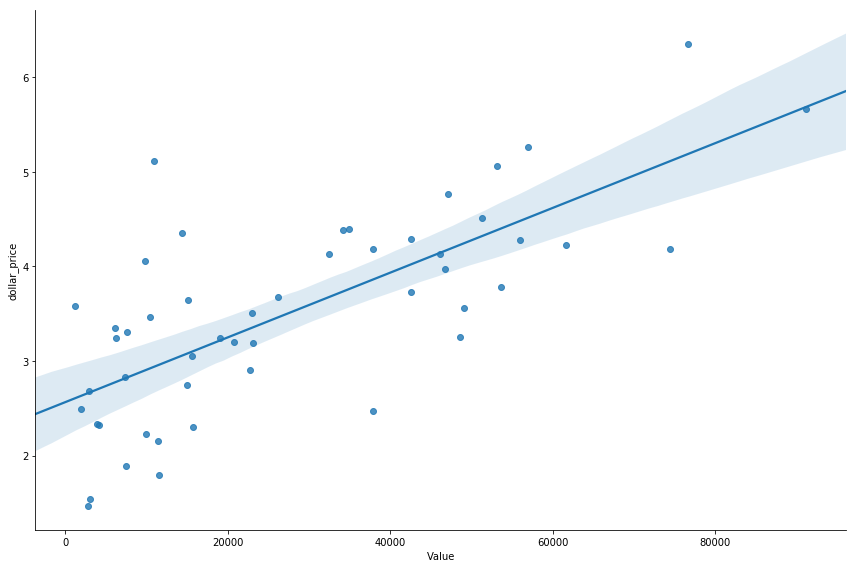

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x="Value", y="dollar_price", data=merged_df, height=8, aspect=1.5)

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


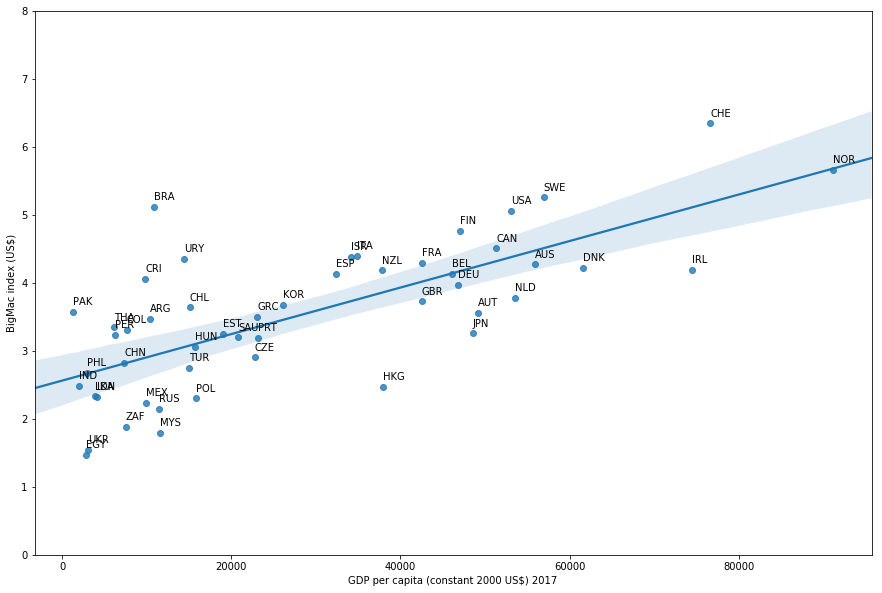

In [10]:
# seaborn.regplot() returns matplotlib.Axes object
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.regplot(x="Value", y="dollar_price", data=merged_df, fit_reg=True)
ax.set_xlabel("GDP per capita (constant 2000 US$) 2017")
ax.set_ylabel("BigMac index (US$)")
ax.set_ylim((0,8))

# Label the country code for those who demonstrate extreme BigMac index
for row in merged_df.itertuples():
    ax.text(row.Value,row.dollar_price+0.1,row.country)

plt.savefig("GDP to Bigmac index", dpi=300)
plt.show()

## Linear regression line (Bigmac index / GDP)

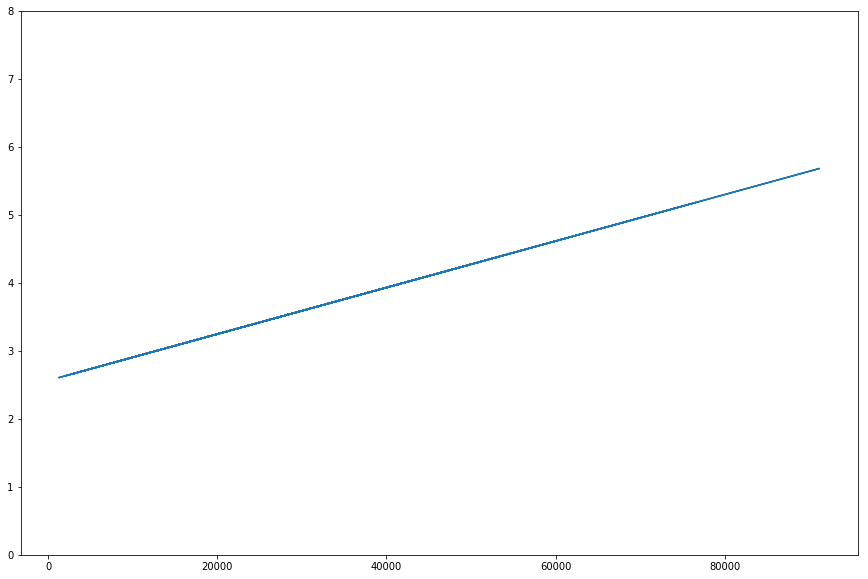

In [11]:
from scipy.stats import linregress

# Calculate linear regression parameters
slope, intercept, r_value, p_value, std_err = linregress(
    merged_df.Value, 
    merged_df.dollar_price
)

ax = plt.gca()
ax.set_ylim((0,8))
plt.plot(
    merged_df.Value,
    merged_df['Value'] * slope + intercept
)

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


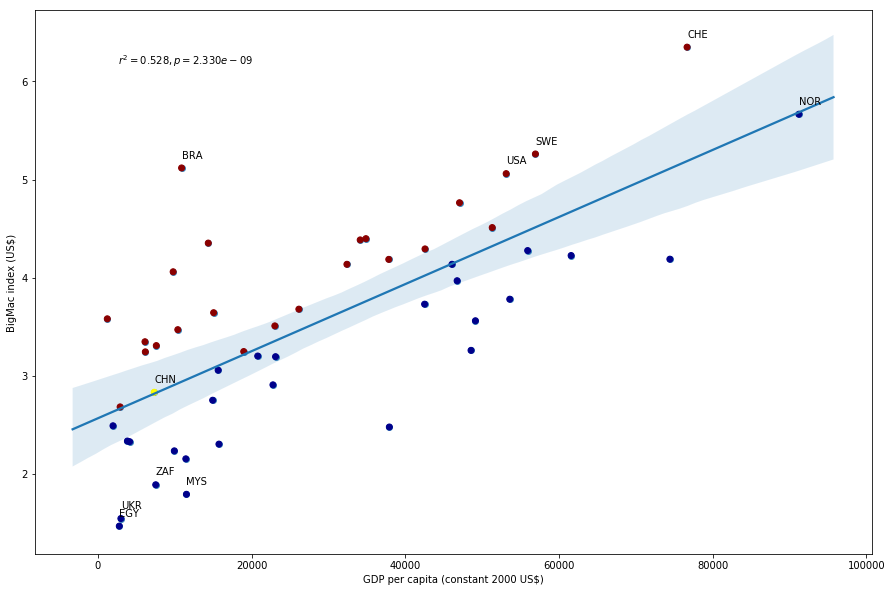

In [12]:
ax = sns.regplot(x="Value", y="dollar_price", data=merged_df)
ax.set_xlabel("GDP per capita (constant 2000 US$)")
ax.set_ylabel("BigMac index (US$)")

colors = []
for row in merged_df.itertuples():
    if row.dollar_price > row.Value * slope + intercept:
        # Color markers as darkred if they are above the regression line
        color = "darkred"
    else:
        # Color markers as darkblue if they are below the regression line
        color = "darkblue"
    
    # Label the country code for those who demonstrate extreme BigMac index
    if row.dollar_price >= 5 or row.dollar_price <= 2:
        ax.text(row.Value,row.dollar_price+0.1,row.country)
        
    # Highlight the marker that corresponds to China
    if row.country == "CHN":
        t = ax.text(row.Value,row.dollar_price+0.1,row.country)
        color = "yellow"
    
    colors.append(color)

# Overlay another scatter plot on top with marker-specific color
ax.scatter(merged_df.Value, merged_df.dollar_price, c=colors)

# Label the r squared value and p value of the linear regression model.
# transform=ax.transAxes indicates that the coordinates are given relative to the axes bounding box, 
# with 0,0 being the lower left of the axes and 1,1 the upper right.
ax.text(0.1, 0.9, "$r^2={0:.3f}, p={1:.3e}$".format(r_value ** 2, p_value), transform=ax.transAxes)

plt.savefig("Section_04_scatter_colored.png", dpi=300)
plt.show()

# Projection to axis (bigmac index distribution + GDP distribution)

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


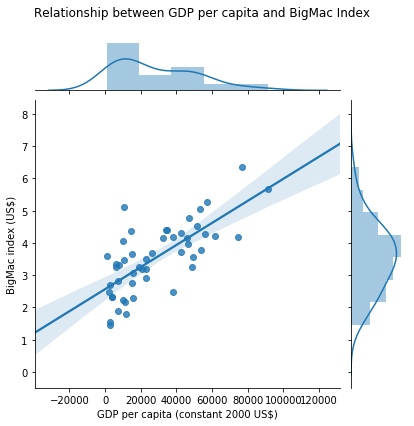

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# seaborn.jointplot() returns a seaborn.JointGrid object
g = sns.jointplot(x="Value", y="dollar_price", data=merged_df, kind="reg")

# Provide custom axes labels through accessing the underlying axes object
# We can get matplotlib.axes.Axes of the scatter plot by calling g.ax_joint
g.ax_joint.set_xlabel("GDP per capita (constant 2000 US$)")
g.ax_joint.set_ylabel("BigMac index (US$)")

# Set the title and adjust the margin
g.fig.suptitle("Relationship between GDP per capita and BigMac Index")
g.fig.subplots_adjust(top=0.9)
plt.savefig("Section_04_jointplot_scatter.png", dpi=300)
plt.show()

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


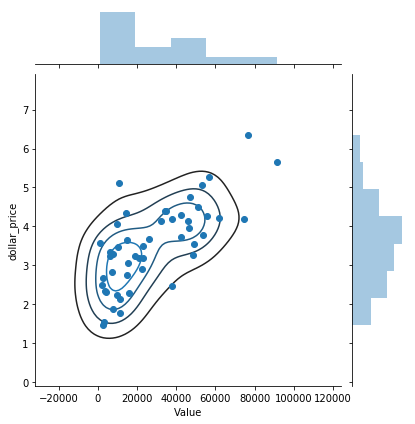

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# seaborn.jointplot() returns a seaborn.JointGrid object
g = (
    sns.jointplot("Value", "dollar_price", data=merged_df).\
    plot_joint(sns.kdeplot, zorder=0, n_levels=6)
)

plt.show()

##### import seaborn as sns
import matplotlib.pyplot as plt


# seaborn.jointplot() returns a seaborn.JointGrid object
g = sns.jointplot(x="Value", y="dollar_price", data=merged_df, kind="hex")

# Provide custom axes labels through accessing the underlying axes object
# We can get matplotlib.axes.Axes of the scatter plot by calling g.ax_joint
g.ax_joint.set_xlabel("GDP per capita (constant 2000 US$)")
g.ax_joint.set_ylabel("BigMac index (US$)")

# Set the title and adjust the margin
g.fig.suptitle("Relationship between GDP per capita and BigMac Index")
g.fig.subplots_adjust(top=0.9)
plt.savefig("Section_04_jointplot_scatter.png", dpi=300)
plt.show()

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


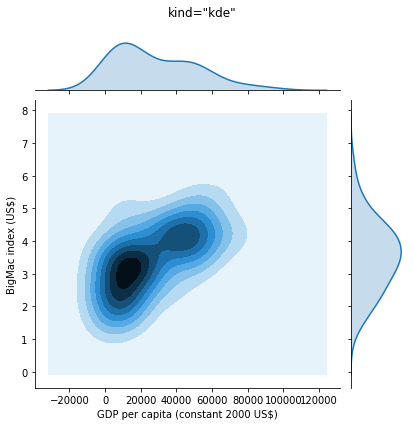

In [15]:
import seaborn as sns
import matplotlib.pyplot as pl

# seaborn.jointplot() returns a seaborn.JointGrid object
g = sns.jointplot(x="Value", y="dollar_price", data=merged_df, kind="kde")

# Provide custom axes labels through accessing the underlying axes object
g.ax_joint.set_xlabel("GDP per capita (constant 2000 US$)")
g.ax_joint.set_ylabel("BigMac index (US$)")
g.fig.suptitle('kind="kde"')
g.fig.subplots_adjust(top=0.9)
plt.savefig("Section_04_jointplot_kde.png", dpi=300)
plt.show()

/home/masa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


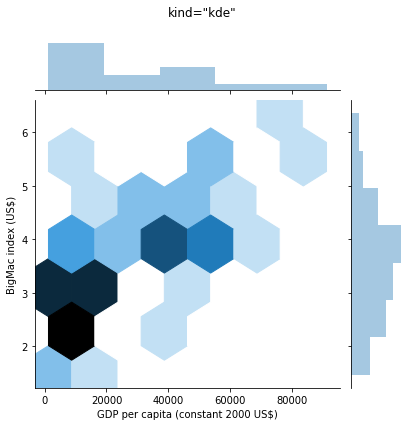

In [16]:
import seaborn as sns
import matplotlib.pyplot as pl

# seaborn.jointplot() returns a seaborn.JointGrid object
g = sns.jointplot(x="Value", y="dollar_price", data=merged_df, kind="hex")

# Provide custom axes labels through accessing the underlying axes object
g.ax_joint.set_xlabel("GDP per capita (constant 2000 US$)")
g.ax_joint.set_ylabel("BigMac index (US$)")
g.fig.suptitle('kind="kde"')
g.fig.subplots_adjust(top=0.9)
plt.savefig("Section_04_jointplot_kde.png", dpi=300)
plt.show()